# Getting Up and Running with Quilt

## Language Documentation

See https://github.com/rigetti/quil/tree/master/rfcs/analog (in particular, `proposal.md` and `spec_changes.md`) for documentation on the Quilt language.

Note that we currently have only a subset of the proposed features in place. In particular,
- `RAW-CAPTURE` is not currently supported
- classical control operations are not supported

## Install quilt version of PyQuil

These are both special branches on the public github repos. Assuming that you are working from your QMI, this could look something like this:

```
source ~/.virtualenvs/venv/bin/activate
pip uninstall pyquil
pip install git+https://github.com/rigetti/pyquil.git@quilt-demo
```

**Note**: It is possible that hotfixes will be pushed to these branches, as the need arises. I suggest checking for updates on the github or via the Rigetti-Horizon slack channel on roughly a daily cadence.

## Construct a `QuantumComputer` object linked to the Quilt compiler

**Note**: Before constructing a quantum computer object, make sure that the `QPU_COMPILER_URL` environment variable is set to the correct value, as shown below. This is so that the compilation calls get routed to the Quilt translator (as opposed to the usual production translator).

In [1]:
import os

os.environ['QPU_COMPILER_URL'] = "https://translation.services.production.qcs.rigetti.com"

Now use `pyquil.get_qc`. 

**Note**: Unlike vanilla pyquil, this will *not* require QPU engagement. This means that you can execute the code below even off of a QPU reservation. However, `qc.run` will always require that you be on a reservation.

In [2]:
from pyquil import Program, get_qc
qc = get_qc("Aspen-8")

As a sanity check, the following call should work.

In [3]:
qc.compiler.get_version_info()

{'quilc': {'quilc': '1.19.0', 'githash': 'cc06660'},
 'qpu_compiler': {'data': {'device_specifications': 1591232153,
   'qpu_specifications': 1591232153,
   'translation_settings': 1591232179},
  'dependencies': {'message_spec': '3.3.0',
   'rpc_framework': '3.3.0',
   'translator': '2.14.0.7.152131677'},
  'version': '1.0.0'}}

## Get Quilt Calibrations

A production QPU has a set of calibrations associated with it. These include frame definitions, gate and measurement calibrations, and custom waveforms. Below we show how to get the default calibrations.

**Note**: This depends on run-time configuration of the QPU, and is likely to vary over time.

In [4]:
cals = qc.compiler.get_quilt_calibrations()

### Frame Definitions

Frame definitions correspond to specific hardware channels. These have a name (e.g. `0 "ro_rx"` for the hardware readout receive channel on Qubit 0), and some metadata (DAC sample rate, initial frame frequency, and a direction).

**Note**: These are fixed and should not be edited. If you wish to set a frame's frequency to one different from its initial frequency, your Quilt program should use `SET-FREQUENCY` (for an absolute value) or `SHIFT-FREQUENCY` (for a relative shift).

In [5]:
for frame, defn in cals.frames.items():
    print(defn)

DEFFRAME 0 1 "cz":
    DIRECTION: "tx"
    INITIAL-FREQUENCY: 221251206.84947222
    CENTER-FREQUENCY: 375000000.0
    HARDWARE-OBJECT: "q0_ff"
    SAMPLE-RATE: 1000000000.0

DEFFRAME 0 7 "cz":
    DIRECTION: "tx"
    INITIAL-FREQUENCY: 149729519.35532
    CENTER-FREQUENCY: 375000000.0
    HARDWARE-OBJECT: "q0_ff"
    SAMPLE-RATE: 1000000000.0

DEFFRAME 1 16 "cz":
    DIRECTION: "tx"
    INITIAL-FREQUENCY: 284752269.0619971
    CENTER-FREQUENCY: 375000000.0
    HARDWARE-OBJECT: "q16_ff"
    SAMPLE-RATE: 1000000000.0

DEFFRAME 2 3 "cz":
    DIRECTION: "tx"
    INITIAL-FREQUENCY: 299464927.45972884
    CENTER-FREQUENCY: 375000000.0
    HARDWARE-OBJECT: "q2_ff"
    SAMPLE-RATE: 1000000000.0

DEFFRAME 2 15 "cz":
    DIRECTION: "tx"
    INITIAL-FREQUENCY: 502317531.7462874
    CENTER-FREQUENCY: 375000000.0
    HARDWARE-OBJECT: "q2_ff"
    SAMPLE-RATE: 1000000000.0

DEFFRAME 3 4 "cz":
    DIRECTION: "tx"
    INITIAL-FREQUENCY: 277828328.376819
    CENTER-FREQUENCY: 375000000.0
    HARDWARE-O

### Gate Calibrations

Gate and Measurement calibrations present the current Quilt specification of Rigetti's native gates. 

In [6]:
for cal in cals.calibrations:
    print(cal)

DEFCAL RX(pi/2) 0:
    FENCE 0
    NONBLOCKING PULSE 0 "rf" drag_gaussian(duration: 1.2e-07, fwhm: 3e-08, t0: 6e-08, anh: -210000000.0, alpha: -2.161864198324805, scale: 0.391675550369374, phase: 0.0, detuning: 0.0)
    FENCE 0

DEFCAL RX(-pi/2) 0:
    FENCE 0
    NONBLOCKING PULSE 0 "rf" drag_gaussian(duration: 1.2e-07, fwhm: 3e-08, t0: 6e-08, anh: -210000000.0, alpha: -2.161864198324805, scale: -0.391675550369374, phase: 0.0, detuning: 0.0)
    FENCE 0

DEFCAL RX(pi) 0:
    FENCE 0
    NONBLOCKING PULSE 0 "rf" drag_gaussian(duration: 1.2e-07, fwhm: 3e-08, t0: 6e-08, anh: -210000000.0, alpha: -2.161864198324805, scale: 0.785911959196345, phase: 0.0, detuning: 0.0)
    FENCE 0

DEFCAL RX(-pi) 0:
    FENCE 0
    NONBLOCKING PULSE 0 "rf" drag_gaussian(duration: 1.2e-07, fwhm: 3e-08, t0: 6e-08, anh: -210000000.0, alpha: -2.161864198324805, scale: -0.785911959196345, phase: 0.0, detuning: 0.0)
    FENCE 0

DEFCAL RX(pi/2) 1:
    FENCE 1
    NONBLOCKING PULSE 1 "rf" drag_gaussian(duration: 

### Waveform Definitions

Certain gates (e.g. `RX` gates above) use template waveforms. Others, notably `CZ` gates, use custom waveforms. The `waveforms` member maps waveform names to their definitions.

In [7]:
cals.waveforms

{'q0_q1_cz/CZ': <pyquil.quilbase.DefWaveform at 0x123d37ad0>,
 'q0_q7_cz/CZ': <pyquil.quilbase.DefWaveform at 0x123d37e50>,
 'q2_q3_cz/CZ': <pyquil.quilbase.DefWaveform at 0x123d37ed0>,
 'q3_q4_cz/CZ': <pyquil.quilbase.DefWaveform at 0x123d37f50>,
 'q4_q5_cz/CZ': <pyquil.quilbase.DefWaveform at 0x123d37fd0>,
 'q5_q6_cz/CZ': <pyquil.quilbase.DefWaveform at 0x123d440d0>,
 'q6_q7_cz/CZ': <pyquil.quilbase.DefWaveform at 0x123d44150>,
 'q1_q16_cz/CZ': <pyquil.quilbase.DefWaveform at 0x123d441d0>,
 'q2_q15_cz/CZ': <pyquil.quilbase.DefWaveform at 0x123d44250>,
 'q11_q12_cz/CZ': <pyquil.quilbase.DefWaveform at 0x123d44290>,
 'q11_q26_cz/CZ': <pyquil.quilbase.DefWaveform at 0x123d44310>,
 'q12_q13_cz/CZ': <pyquil.quilbase.DefWaveform at 0x123d44390>,
 'q13_q14_cz/CZ': <pyquil.quilbase.DefWaveform at 0x123d44410>,
 'q14_q15_cz/CZ': <pyquil.quilbase.DefWaveform at 0x123d44490>,
 'q15_q16_cz/CZ': <pyquil.quilbase.DefWaveform at 0x123d44510>,
 'q16_q17_cz/CZ': <pyquil.quilbase.DefWaveform at 0x123d

Here is what one of these definitions looks like.

In [8]:
print(next(iter(cals.waveforms.values())))

DEFWAVEFORM q0_q1_cz/CZ:
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018064022121015185, 0.002602354539486283, 0.019961038851271047, 0.08432636113106678, 0.20816391205664736, 0.332001462982228, 0.3963667852620237, 0.4137254695738085, 0.41614718389208466, 0.41632127931881846, 0.4163277018462348, 0.41632782294476345, 0.4163278241076116, 0.41632782411328073, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947, 0.4163278241132947

## Compiling and running a Quilt Program


There are three ways to access the compiler from PyQuil:
- `qc.compile` is the usual pipeline, and **only works for Quil code**
- `qc.compiler.quil_to_native_quil` is the entry point for compiling Quil to native Quil
- `qc.compiler.native_quil_to_executable` is the entry point for compiling **Quilt** programs

In particular, the usual workflow of just delegating to `qc.compile` does not currently work with Quilt. If you wish to use Quilt right now, your workflow should involve
1. calling `qc.compiler.quil_to_native_quil` on code blocks which do not involve Quilt or Quilt calibrations
2. subsequently calling `qc.compiler.native_quil_to_executable` on blocks involving Quilt

### Compiling Quil Programs

`qc.compiler.native_quil_to_executable` requires native Quil + Quilt operations. In particular, it is assumed that the only gates used are those Rigetti native gates, or ones for which you have provided explicit calibrations. For example, the program below expresses

```
DECLARE ro BIT
H 0
CNOT 0 1
MEASURE 0 ro
```

using Rigetti native gates by first using `qc.compiler.quil_to_native_quil`.

In [9]:
prog = Program(
    'DECLARE ro BIT',
    'H 0',
    'CNOT 0 1',
    'MEASURE 0 ro'
)
compiled = qc.compiler.quil_to_native_quil(prog)
print(compiled)

DECLARE ro BIT[1]
RZ(pi/2) 0
RX(pi/2) 0
RZ(-pi/2) 1
RX(pi/2) 1
CZ 1 0
RZ(-pi/2) 0
MEASURE 0 ro[0]
RX(-pi/2) 1
RZ(pi/2) 1
HALT



In [10]:
exe = qc.compiler.native_quil_to_executable(compiled)

**Note**: The above compilation may be done even when not on an active QPU reservation. However,
- as always, the executable cannot be run until on an active QPU reservation
- the QPU settings used for compilation may go stale

Therefore, we suggest that although you may rely on `qc.compiler.native_quil_to_executable` for development purposes (for example, to verify correct Quilt syntax), when executing on a QPU all Quilt programs should be compiled afresh.

Running the executable proceeds as before:

In [11]:
qc.run(exe)

array([[1]])

### Another example: a simple T1 experiment

As an example of mixing Quil with the new Quilt instructions, we consider a simple T1 experiment. In short, we
- excite the qubit state
- wait some amount of time
- measure out

In this example, we do not do any further data analysis. The purpose here is simply to demonstrate how to compile and run a Quilt program.

In [12]:
def t1_program(time, qubit, num_shots=1000):
    prog = Program( "DECLARE ro BIT\n"
                   f"RX(pi) {qubit}\n"
                   f"FENCE 0\n"
                   f"DELAY {qubit} {time}\n"
                   f"MEASURE {qubit} ro")
    prog.wrap_in_numshots_loop(num_shots)
    return prog

In [13]:
import numpy as np

probs = []

times = np.geomspace(20e-9, 60e-4, 20)
for time in times:
    prog = t1_program(time, 0)
    exe = qc.compiler.native_quil_to_executable(prog)
    results = qc.run(exe)
    prob = np.sum(results) / results.size
    probs.append(prob)
    print(f"time: {time:.2e} \tprob: {prob:.2}")

time: 2.00e-08 	prob: 0.97
time: 3.88e-08 	prob: 0.96
time: 7.54e-08 	prob: 0.94
time: 1.47e-07 	prob: 0.92
time: 2.85e-07 	prob: 0.87
time: 5.53e-07 	prob: 0.8
time: 1.07e-06 	prob: 0.77
time: 2.08e-06 	prob: 0.64
time: 4.05e-06 	prob: 0.52
time: 7.86e-06 	prob: 0.34
time: 1.53e-05 	prob: 0.23
time: 2.96e-05 	prob: 0.06
time: 5.76e-05 	prob: 0.051
time: 1.12e-04 	prob: 0.042
time: 2.17e-04 	prob: 0.043
time: 4.22e-04 	prob: 0.046
time: 8.19e-04 	prob: 0.044
time: 1.59e-03 	prob: 0.043
time: 3.09e-03 	prob: 0.039
time: 6.00e-03 	prob: 0.043


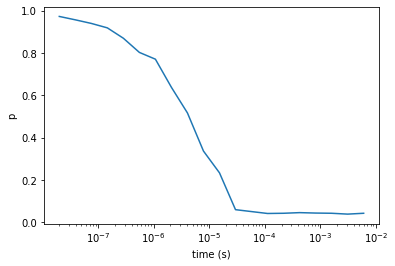

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.semilogx(times, probs, '-')
plt.xlabel('time (s)')
plt.ylabel('p')
plt.show()

### Using a Custom Calibration

All gate and measure applications in a Quilt program are translated according to either user-supplied or Rigetti calibrations. To easily check which calibration applies to a specific gate, use the `Program.match_calibrations` method.

In [15]:
from math import pi
from pyquil.gates import RX

print(cals.get_calibration(RX(pi, 0)))

DEFCAL RX(pi) 0:
    FENCE 0
    NONBLOCKING PULSE 0 "rf" drag_gaussian(duration: 1.2e-07, fwhm: 3e-08, t0: 6e-08, anh: -210000000.0, alpha: -2.161864198324805, scale: 0.785911959196345, phase: 0.0, detuning: 0.0)
    FENCE 0



None of the above programs needed us to specify calibrations. By default, the Rigetti native calibrations are used. However, if you specify a calibration in a program, it will take precedence over the native calibrations.

In [16]:
prog = t1_program(1e-6, 0)

# Note: we did NOT specify a calibration for RX(pi) 0 in our previous program
assert prog.match_calibrations(RX(pi, 0)) is None
# The Quilt translator provided the default: namely, the same calibration we obtained for ourselves
# with `qc.compiler.get_quilt_calibrations()`.

In the example below, we use a custom calibration, we conjugate the usual pulse with a frequency shift. There's no motivation for the particular value used, beyond simply showing what is possible.

In [17]:
prog = Program("""DEFCAL RX(pi/2) 0:
    FENCE 0
    SET-SCALE 0 "rf" 0.353088482172993
    SHIFT-FREQUENCY 0 "rf" 1e6
    NONBLOCKING PULSE 0 "rf" drag_gaussian(duration: 6.000000000000001e-08, fwhm: 1.5000000000000002e-08, t0: 3.0000000000000004e-08, anh: -210000000.0, alpha: 6.389096630631076)
    SHIFT-FREQUENCY 0 "rf" -1e6
    FENCE 0

DECLARE ro BIT
RX(pi/2) 0
MEASURE 0 ro""")
print(prog)

DEFCAL RX(pi/2) 0:
    FENCE 0
    SET-SCALE 0 "rf" 0.353088482172993
    SHIFT-FREQUENCY 0 "rf" 1000000.0
    NONBLOCKING PULSE 0 "rf" drag_gaussian(duration: 6.000000000000001e-08, fwhm: 1.5000000000000002e-08, t0: 3.0000000000000004e-08, anh: -210000000.0, alpha: 6.389096630631076)
    SHIFT-FREQUENCY 0 "rf" -1000000.0
    FENCE 0

DECLARE ro BIT[1]
RX(pi/2) 0
MEASURE 0 ro[0]



In [18]:
print(prog.get_calibration(RX(pi/2, 0)))

DEFCAL RX(pi/2) 0:
    FENCE 0
    SET-SCALE 0 "rf" 0.353088482172993
    SHIFT-FREQUENCY 0 "rf" 1000000.0
    NONBLOCKING PULSE 0 "rf" drag_gaussian(duration: 6.000000000000001e-08, fwhm: 1.5000000000000002e-08, t0: 3.0000000000000004e-08, anh: -210000000.0, alpha: 6.389096630631076)
    SHIFT-FREQUENCY 0 "rf" -1000000.0
    FENCE 0



In [19]:
exe = qc.compiler.native_quil_to_executable(prog)

In [20]:
qc.run(exe)

array([[0]])

Of course, it is not required to use calibrations. One can construct an equivalent program by replacing the `RX` gate with the body of the calibration:

In [21]:
prog = Program("""
DECLARE ro BIT
FENCE 0
SET-SCALE 0 "rf" 0.353088482172993
SHIFT-FREQUENCY 0 "rf" 1e6
NONBLOCKING PULSE 0 "rf" drag_gaussian(duration: 6.000000000000001e-08, fwhm: 1.5000000000000002e-08, t0: 3.0000000000000004e-08, anh: -210000000.0, alpha: 6.389096630631076)
SHIFT-FREQUENCY 0 "rf" -1e6
FENCE 0
MEASURE 0 ro
""".strip())

In [22]:
exe = qc.compiler.native_quil_to_executable(prog)

In [23]:
qc.run(exe)

array([[0]])

#### Parametric Calibrations

Some calibrations (e.g. for `RX`) are defined for specific parameter values. Others may depend on general symbolic values, as with `RZ`.

In [24]:
from pyquil.gates import RZ

print(cals.get_calibration(RZ(pi,0)))

DEFCAL RZ(%theta) 0:
    FENCE 0
    SHIFT-PHASE 0 "rf" -1.0*%theta
    SHIFT-PHASE 0 1 "xy" -0.5*%theta
    FENCE 0



To get more information about how the matching calibration applies to a specific gate, use `Program.match_calibrations`. The result is a `CalibrationMatch` object which indicates not just the calibration, but the value for parameters.

In [25]:
match = cals.match_calibrations(RZ(pi,0))
print(match.cal)
print(match.settings)

DEFCAL RZ(%theta) 0:
    FENCE 0
    SHIFT-PHASE 0 "rf" -1.0*%theta
    SHIFT-PHASE 0 1 "xy" -0.5*%theta
    FENCE 0

{Parameter('theta'): 3.141592653589793}


You may conveniently recover the body of the calibration, with the matched parameters substituted, using `Program.calibrate`.

In [26]:
instrs = cals.calibrate(RZ(pi,0))
for instr in instrs:
    print(instr)

FENCE 0
SHIFT-PHASE 0 "rf" -3.141592653589793
SHIFT-PHASE 0 1 "xy" -1.5707963267948966
FENCE 0


### Non-Native Gates
As mentioned above, the `qc.compiler.native_quil_to_executable` call will provide calibrations for Rigetti native gates, if they are not provided by a user. However, a program with non-native gates and no corresponding user-provided calibrations will result in a compilation failure.

In [27]:
prog = Program("DECLARE ro BIT\n"
               "H 0\n"
               "CNOT 0 1\n"
               "MEASURE 0 ro")

try:
    qc.compiler.native_quil_to_executable(prog)
except Exception as e:
    print("Fails on non-native operations {H, CNOT} as expected.")

ERROR - QPU Compiler native_quilt_to_binary failed: Unable to find matching calibration for H 0.


Fails on non-native operations {H, CNOT} as expected.
